In [6]:
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
import pandas as pd
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
#plt.switch_backend('agg')

In [7]:
#保存打印文件
f = open("1.5torchGRU.txt", 'a+')

In [8]:
#读取数据集，进行划分
def sliding_window(seq,window_size):
    result = []
    for i in range(len(seq)- window_size):
        result.append(seq[i: i+window_size])
    return result

data = np.load("./实验4-数据/高速公路传感器数据/PEMS04/PEMS04.npz")
#因为数据集过大，这里只取了第一个传感器的数据
data = data["data"][:,0:1,0:1]
#归一化
dmin,dmax = data.min(),data.max()
data = (data - dmin) / (dmax - dmin)
sensordata_num,sensor_num,_ = data.shape
train_set,test_set = [],[]
for  i in range(sensor_num) :
    train_seq = data[:int(sensordata_num*0.8),i,:]
    test_seq = data[int(sensordata_num*0.8):,i,:]
    train_set += sliding_window(train_seq,window_size=13)
    test_set += sliding_window(test_seq,window_size=13)
train_set,test_set= np.array(train_set).squeeze(), np.array(test_set).squeeze()
print(train_set.shape,test_set.shape)
print(train_set,test_set)

(13580, 13) (3386, 13)
[[0.09904153 0.09744409 0.11341853 ... 0.2284345  0.22683706 0.23162939]
 [0.09744409 0.11341853 0.13738019 ... 0.22683706 0.23162939 0.25878594]
 [0.11341853 0.13738019 0.16453674 ... 0.23162939 0.25878594 0.20127796]
 ...
 [0.0798722  0.09105431 0.06389776 ... 0.08626198 0.05591054 0.07667732]
 [0.09105431 0.06389776 0.07188498 ... 0.05591054 0.07667732 0.07827476]
 [0.06389776 0.07188498 0.07507987 ... 0.07667732 0.07827476 0.1086262 ]] [[0.11182109 0.13897764 0.08785942 ... 0.15335463 0.15974441 0.17891374]
 [0.13897764 0.08785942 0.07827476 ... 0.15974441 0.17891374 0.16453674]
 [0.08785942 0.07827476 0.07188498 ... 0.17891374 0.16453674 0.15974441]
 ...
 [0.24920128 0.21246006 0.17891374 ... 0.11182109 0.1086262  0.11980831]
 [0.21246006 0.17891374 0.19648562 ... 0.1086262  0.11980831 0.10543131]
 [0.17891374 0.19648562 0.1884984  ... 0.11980831 0.10543131 0.12300319]]


In [9]:
device = 'cpu'
torch_gru = nn.GRU(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
output_model = nn.Linear(32, 1)

In [10]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(list(torch_gru.parameters()) + list(output_model.parameters()), lr=0.0001)

In [11]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [12]:
def next_batch(data, batch_size):
    data_length = len(data)
    num_batches = math.ceil(data_length / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

In [13]:
#反归一化
def denormalize(x):
    return x * (dmax - dmin) + dmin

In [14]:
train_log = []
test_log = []
#开始时间
timestart = time.time()
trained_batches = 0 #记录多少个batch 
for epoch in range(100):
   
    total_1oss = 0 #记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=128):
        #每一个batch的开始时间
        batchstart = time.time()
        
        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前12个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :12], batch[:, -1]
        out, hidden = torch_gru(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
        out = output_model(out[:, -1, :])
        prediction = out.squeeze(-1)  # (batch)
        
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #correct += (prediction == label).sum().item()
        #累加loss
        #total_1oss += loss.item( )
        trained_batches += 1
         #计算平均oss与准确率
        #train_loss = total_1oss / train_batch_num
        #train_log.append(train_loss)   
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        #if trained_batches % 100 == 0:
        train_log.append(loss.detach().cpu().numpy().tolist());
        train_batch_time = (time.time() - batchstart)
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time))
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time),file=f)
    
        
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            #每一个batch的开始时间
            batch_test_start = time.time()
            #在每个epoch上测试
            all_prediction = []
            for batch in next_batch(test_set, batch_size=128):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :12], batch[:, -1]
                out, hidden = torch_gru(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
                out = output_model(out[:, -1, :])
                prediction = out.squeeze(-1)  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())

            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            # 没有进行反归一化操作。
            #all_prediction = denormalize(all_prediction)
            #all_label = denormalize(all_label)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time))
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time),file=f)

        #每一个epoch的结束时间
        #elapsed = (time.time() - epochstart)
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed))
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed),file=f)
    
#计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs'%(timesum))
print('The total time is %fs'%(timesum),file=f)
f.close()

batch 1, train_loss 0.137399,Time used 0.094747s
batch 2, train_loss 0.136737,Time used 0.017952s
batch 3, train_loss 0.149555,Time used 0.016955s
batch 4, train_loss 0.120188,Time used 0.016956s
batch 5, train_loss 0.134995,Time used 0.017951s
batch 6, train_loss 0.125270,Time used 0.016954s
batch 7, train_loss 0.121394,Time used 0.016955s
batch 8, train_loss 0.146843,Time used 0.016955s
batch 9, train_loss 0.137558,Time used 0.016954s
batch 10, train_loss 0.143544,Time used 0.016955s
batch 11, train_loss 0.112244,Time used 0.017952s
batch 12, train_loss 0.122139,Time used 0.016955s
batch 13, train_loss 0.130828,Time used 0.018949s
batch 14, train_loss 0.144336,Time used 0.018950s
batch 15, train_loss 0.134299,Time used 0.017951s
batch 16, train_loss 0.110659,Time used 0.015959s
batch 17, train_loss 0.118626,Time used 0.015957s
batch 18, train_loss 0.148142,Time used 0.014961s
batch 19, train_loss 0.118134,Time used 0.016954s
batch 20, train_loss 0.138784,Time used 0.016955s
batch 21,

batch 166, train_loss 0.048709,Time used 0.016466s
batch 167, train_loss 0.042229,Time used 0.016955s
batch 168, train_loss 0.043938,Time used 0.022939s
batch 169, train_loss 0.036381,Time used 0.018366s
batch 170, train_loss 0.040154,Time used 0.016955s
batch 171, train_loss 0.043268,Time used 0.017951s
batch 172, train_loss 0.036716,Time used 0.015957s
batch 173, train_loss 0.038394,Time used 0.016955s
batch 174, train_loss 0.047748,Time used 0.017952s
batch 175, train_loss 0.043523,Time used 0.016955s
batch 176, train_loss 0.049425,Time used 0.016955s
batch 177, train_loss 0.044070,Time used 0.015958s
batch 178, train_loss 0.040185,Time used 0.016954s
batch 179, train_loss 0.043400,Time used 0.015958s
batch 180, train_loss 0.042631,Time used 0.015958s
batch 181, train_loss 0.046252,Time used 0.016954s
batch 182, train_loss 0.037959,Time used 0.015976s
batch 183, train_loss 0.043672,Time used 0.016955s
batch 184, train_loss 0.042292,Time used 0.015957s
batch 185, train_loss 0.039923,

batch 323, train_loss 0.030538,Time used 0.017951s
batch 324, train_loss 0.035007,Time used 0.017952s
batch 325, train_loss 0.038155,Time used 0.016954s
batch 326, train_loss 0.035974,Time used 0.018950s
batch 327, train_loss 0.032398,Time used 0.017952s
batch 328, train_loss 0.033163,Time used 0.016954s
batch 329, train_loss 0.037294,Time used 0.016955s
batch 330, train_loss 0.030866,Time used 0.016955s
batch 331, train_loss 0.032996,Time used 0.015958s
batch 332, train_loss 0.028391,Time used 0.015957s
batch 333, train_loss 0.032476,Time used 0.016954s
batch 334, train_loss 0.031720,Time used 0.016954s
batch 335, train_loss 0.032631,Time used 0.016955s
batch 336, train_loss 0.033226,Time used 0.016955s
batch 337, train_loss 0.032063,Time used 0.016954s
batch 338, train_loss 0.031951,Time used 0.017952s
batch 339, train_loss 0.035148,Time used 0.017952s
batch 340, train_loss 0.034753,Time used 0.015957s
batch 341, train_loss 0.030639,Time used 0.014960s
batch 342, train_loss 0.033448,

batch 488, train_loss 0.027268,Time used 0.016955s
batch 489, train_loss 0.030368,Time used 0.017951s
batch 490, train_loss 0.022390,Time used 0.017952s
batch 491, train_loss 0.024182,Time used 0.016954s
batch 492, train_loss 0.026965,Time used 0.016955s
batch 493, train_loss 0.027202,Time used 0.016955s
batch 494, train_loss 0.028684,Time used 0.015957s
batch 495, train_loss 0.024490,Time used 0.015958s
batch 496, train_loss 0.026618,Time used 0.015957s
batch 497, train_loss 0.027574,Time used 0.015957s
batch 498, train_loss 0.028539,Time used 0.014960s
batch 499, train_loss 0.028659,Time used 0.016955s
batch 500, train_loss 0.023372,Time used 0.019947s
***************************test_batch 500, test_rmse_loss 0.161909,test_mae_loss 0.137646,test_mape_loss 90.916227,Time used 0.206972s
batch 501, train_loss 0.025463,Time used 0.017953s
batch 502, train_loss 0.028576,Time used 0.016955s
batch 503, train_loss 0.026627,Time used 0.017952s
batch 504, train_loss 0.025402,Time used 0.015957

batch 652, train_loss 0.020213,Time used 0.015957s
batch 653, train_loss 0.016019,Time used 0.017952s
batch 654, train_loss 0.020842,Time used 0.015957s
batch 655, train_loss 0.020121,Time used 0.015958s
batch 656, train_loss 0.018127,Time used 0.014960s
batch 657, train_loss 0.016700,Time used 0.014960s
batch 658, train_loss 0.019968,Time used 0.014961s
batch 659, train_loss 0.019679,Time used 0.015957s
batch 660, train_loss 0.018915,Time used 0.016954s
batch 661, train_loss 0.016097,Time used 0.015958s
batch 662, train_loss 0.023664,Time used 0.015957s
batch 663, train_loss 0.018173,Time used 0.015958s
batch 664, train_loss 0.017820,Time used 0.015957s
batch 665, train_loss 0.017013,Time used 0.016955s
batch 666, train_loss 0.014136,Time used 0.016954s
batch 667, train_loss 0.014548,Time used 0.016955s
batch 668, train_loss 0.019583,Time used 0.015958s
batch 669, train_loss 0.020043,Time used 0.015958s
batch 670, train_loss 0.019509,Time used 0.015958s
batch 671, train_loss 0.014225,

batch 812, train_loss 0.009302,Time used 0.016955s
batch 813, train_loss 0.010761,Time used 0.016955s
batch 814, train_loss 0.010124,Time used 0.016955s
batch 815, train_loss 0.009744,Time used 0.015958s
batch 816, train_loss 0.010663,Time used 0.015958s
batch 817, train_loss 0.009837,Time used 0.014960s
batch 818, train_loss 0.009054,Time used 0.015958s
batch 819, train_loss 0.008834,Time used 0.015958s
batch 820, train_loss 0.008156,Time used 0.016954s
batch 821, train_loss 0.009181,Time used 0.017952s
batch 822, train_loss 0.009982,Time used 0.016955s
batch 823, train_loss 0.008562,Time used 0.017952s
batch 824, train_loss 0.009530,Time used 0.017953s
batch 825, train_loss 0.007879,Time used 0.016955s
batch 826, train_loss 0.010778,Time used 0.016955s
batch 827, train_loss 0.008250,Time used 0.015957s
batch 828, train_loss 0.009980,Time used 0.015958s
batch 829, train_loss 0.008417,Time used 0.015958s
batch 830, train_loss 0.008900,Time used 0.015957s
batch 831, train_loss 0.009098,

batch 981, train_loss 0.006323,Time used 0.015957s
batch 982, train_loss 0.003947,Time used 0.016954s
batch 983, train_loss 0.005170,Time used 0.016465s
batch 984, train_loss 0.004986,Time used 0.016955s
batch 985, train_loss 0.004796,Time used 0.016955s
batch 986, train_loss 0.005195,Time used 0.016955s
batch 987, train_loss 0.004182,Time used 0.015957s
batch 988, train_loss 0.004710,Time used 0.015958s
batch 989, train_loss 0.003757,Time used 0.016956s
batch 990, train_loss 0.004069,Time used 0.016955s
batch 991, train_loss 0.004769,Time used 0.015957s
batch 992, train_loss 0.004276,Time used 0.015958s
batch 993, train_loss 0.005722,Time used 0.017952s
batch 994, train_loss 0.004921,Time used 0.015959s
batch 995, train_loss 0.005001,Time used 0.015957s
batch 996, train_loss 0.003659,Time used 0.014960s
batch 997, train_loss 0.004794,Time used 0.014960s
batch 998, train_loss 0.005148,Time used 0.015958s
batch 999, train_loss 0.006500,Time used 0.015956s
batch 1000, train_loss 0.003924

batch 1289, train_loss 0.003929,Time used 0.014961s
batch 1290, train_loss 0.003864,Time used 0.015958s
batch 1291, train_loss 0.004135,Time used 0.015957s
batch 1292, train_loss 0.004664,Time used 0.015957s
batch 1293, train_loss 0.003604,Time used 0.015957s
batch 1294, train_loss 0.004353,Time used 0.015958s
batch 1295, train_loss 0.004598,Time used 0.016954s
batch 1296, train_loss 0.004236,Time used 0.015957s
batch 1297, train_loss 0.006166,Time used 0.014960s
batch 1298, train_loss 0.004130,Time used 0.015958s
batch 1299, train_loss 0.003966,Time used 0.015957s
batch 1300, train_loss 0.005144,Time used 0.015958s
***************************test_batch 1300, test_rmse_loss 0.066700,test_mae_loss 0.049312,test_mape_loss 17.819901,Time used 0.202458s
batch 1301, train_loss 0.003253,Time used 0.017951s
batch 1302, train_loss 0.004651,Time used 0.018950s
batch 1303, train_loss 0.003813,Time used 0.016954s
batch 1304, train_loss 0.003963,Time used 0.016955s
batch 1305, train_loss 0.004385,

batch 1442, train_loss 0.003477,Time used 0.015957s
batch 1443, train_loss 0.003843,Time used 0.017952s
batch 1444, train_loss 0.004364,Time used 0.016954s
batch 1445, train_loss 0.004212,Time used 0.015957s
batch 1446, train_loss 0.004136,Time used 0.016955s
batch 1447, train_loss 0.005498,Time used 0.015957s
batch 1448, train_loss 0.003100,Time used 0.014961s
batch 1449, train_loss 0.005097,Time used 0.015957s
batch 1450, train_loss 0.003284,Time used 0.015957s
batch 1451, train_loss 0.004414,Time used 0.015957s
batch 1452, train_loss 0.005357,Time used 0.016955s
batch 1453, train_loss 0.005558,Time used 0.015957s
batch 1454, train_loss 0.003840,Time used 0.017953s
batch 1455, train_loss 0.004261,Time used 0.016955s
batch 1456, train_loss 0.004141,Time used 0.015958s
batch 1457, train_loss 0.004567,Time used 0.015958s
batch 1458, train_loss 0.004645,Time used 0.015959s
batch 1459, train_loss 0.004961,Time used 0.014961s
batch 1460, train_loss 0.002352,Time used 0.015958s
batch 1461, 

batch 1598, train_loss 0.005184,Time used 0.015958s
batch 1599, train_loss 0.005833,Time used 0.016955s
batch 1600, train_loss 0.005168,Time used 0.016955s
***************************test_batch 1600, test_rmse_loss 0.065509,test_mae_loss 0.048165,test_mape_loss 16.756838,Time used 0.201462s
batch 1601, train_loss 0.003554,Time used 0.014960s
batch 1602, train_loss 0.004948,Time used 0.015957s
batch 1603, train_loss 0.003811,Time used 0.014961s
batch 1604, train_loss 0.003709,Time used 0.013962s
batch 1605, train_loss 0.002313,Time used 0.007979s
batch 1606, train_loss 0.005070,Time used 0.015958s
batch 1607, train_loss 0.004951,Time used 0.014961s
batch 1608, train_loss 0.004369,Time used 0.014959s
batch 1609, train_loss 0.005348,Time used 0.032912s
batch 1610, train_loss 0.003627,Time used 0.016954s
batch 1611, train_loss 0.004193,Time used 0.017952s
batch 1612, train_loss 0.003174,Time used 0.027925s
batch 1613, train_loss 0.004415,Time used 0.024934s
batch 1614, train_loss 0.003958,

batch 1756, train_loss 0.003539,Time used 0.014961s
batch 1757, train_loss 0.003171,Time used 0.015958s
batch 1758, train_loss 0.003821,Time used 0.015958s
batch 1759, train_loss 0.004902,Time used 0.014960s
batch 1760, train_loss 0.003583,Time used 0.014960s
batch 1761, train_loss 0.004101,Time used 0.014960s
batch 1762, train_loss 0.004245,Time used 0.013963s
batch 1763, train_loss 0.005436,Time used 0.014960s
batch 1764, train_loss 0.004121,Time used 0.013964s
batch 1765, train_loss 0.003760,Time used 0.014960s
batch 1766, train_loss 0.004208,Time used 0.017953s
batch 1767, train_loss 0.005300,Time used 0.018460s
batch 1768, train_loss 0.003344,Time used 0.022939s
batch 1769, train_loss 0.005155,Time used 0.022939s
batch 1770, train_loss 0.003404,Time used 0.016954s
batch 1771, train_loss 0.004192,Time used 0.017952s
batch 1772, train_loss 0.003108,Time used 0.016955s
batch 1773, train_loss 0.003543,Time used 0.016956s
batch 1774, train_loss 0.004545,Time used 0.016955s
batch 1775, 

batch 1912, train_loss 0.003298,Time used 0.015957s
batch 1913, train_loss 0.003681,Time used 0.014960s
batch 1914, train_loss 0.004993,Time used 0.013962s
batch 1915, train_loss 0.003705,Time used 0.013963s
batch 1916, train_loss 0.003164,Time used 0.015957s
batch 1917, train_loss 0.003410,Time used 0.013964s
batch 1918, train_loss 0.003106,Time used 0.013963s
batch 1919, train_loss 0.003872,Time used 0.015957s
batch 1920, train_loss 0.004820,Time used 0.015958s
batch 1921, train_loss 0.004744,Time used 0.015956s
batch 1922, train_loss 0.003898,Time used 0.015958s
batch 1923, train_loss 0.003214,Time used 0.014960s
batch 1924, train_loss 0.004667,Time used 0.015958s
batch 1925, train_loss 0.004481,Time used 0.014961s
batch 1926, train_loss 0.004171,Time used 0.008977s
batch 1927, train_loss 0.004051,Time used 0.020944s
batch 1928, train_loss 0.005219,Time used 0.018950s
batch 1929, train_loss 0.004417,Time used 0.015958s
batch 1930, train_loss 0.004009,Time used 0.015958s
batch 1931, 

batch 2069, train_loss 0.003385,Time used 0.016954s
batch 2070, train_loss 0.004601,Time used 0.016954s
batch 2071, train_loss 0.004281,Time used 0.015957s
batch 2072, train_loss 0.004602,Time used 0.015957s
batch 2073, train_loss 0.004542,Time used 0.017952s
batch 2074, train_loss 0.004558,Time used 0.016955s
batch 2075, train_loss 0.003844,Time used 0.016955s
batch 2076, train_loss 0.003275,Time used 0.015958s
batch 2077, train_loss 0.002606,Time used 0.015957s
batch 2078, train_loss 0.004530,Time used 0.015957s
batch 2079, train_loss 0.003470,Time used 0.014960s
batch 2080, train_loss 0.004847,Time used 0.015958s
batch 2081, train_loss 0.005631,Time used 0.016955s
batch 2082, train_loss 0.004169,Time used 0.016955s
batch 2083, train_loss 0.004157,Time used 0.015957s
batch 2084, train_loss 0.004078,Time used 0.014959s
batch 2085, train_loss 0.004190,Time used 0.014960s
batch 2086, train_loss 0.004996,Time used 0.014960s
batch 2087, train_loss 0.004488,Time used 0.014959s
batch 2088, 

batch 2223, train_loss 0.002777,Time used 0.014961s
batch 2224, train_loss 0.004829,Time used 0.015956s
batch 2225, train_loss 0.004044,Time used 0.016010s
batch 2226, train_loss 0.003601,Time used 0.014960s
batch 2227, train_loss 0.003823,Time used 0.013963s
batch 2228, train_loss 0.003418,Time used 0.014961s
batch 2229, train_loss 0.004516,Time used 0.014960s
batch 2230, train_loss 0.003940,Time used 0.012966s
batch 2231, train_loss 0.004321,Time used 0.026929s
batch 2232, train_loss 0.006383,Time used 0.026928s
batch 2233, train_loss 0.003318,Time used 0.014959s
batch 2234, train_loss 0.003878,Time used 0.015957s
batch 2235, train_loss 0.003537,Time used 0.016956s
batch 2236, train_loss 0.003652,Time used 0.015956s
batch 2237, train_loss 0.004290,Time used 0.015957s
batch 2238, train_loss 0.005096,Time used 0.014961s
batch 2239, train_loss 0.004877,Time used 0.014960s
batch 2240, train_loss 0.003864,Time used 0.015958s
batch 2241, train_loss 0.004358,Time used 0.015958s
batch 2242, 

batch 2384, train_loss 0.003970,Time used 0.014960s
batch 2385, train_loss 0.003217,Time used 0.015957s
batch 2386, train_loss 0.004575,Time used 0.016954s
batch 2387, train_loss 0.003051,Time used 0.015958s
batch 2388, train_loss 0.003330,Time used 0.014961s
batch 2389, train_loss 0.005135,Time used 0.015958s
batch 2390, train_loss 0.003480,Time used 0.016954s
batch 2391, train_loss 0.004330,Time used 0.018950s
batch 2392, train_loss 0.005206,Time used 0.027925s
batch 2393, train_loss 0.003828,Time used 0.016955s
batch 2394, train_loss 0.002512,Time used 0.015957s
batch 2395, train_loss 0.003970,Time used 0.017952s
batch 2396, train_loss 0.003241,Time used 0.015957s
batch 2397, train_loss 0.004066,Time used 0.015957s
batch 2398, train_loss 0.003124,Time used 0.014960s
batch 2399, train_loss 0.004033,Time used 0.013963s
batch 2400, train_loss 0.003211,Time used 0.013963s
***************************test_batch 2400, test_rmse_loss 0.063351,test_mae_loss 0.046138,test_mape_loss 15.144374,

batch 2547, train_loss 0.002424,Time used 0.013963s
batch 2548, train_loss 0.003778,Time used 0.014960s
batch 2549, train_loss 0.003876,Time used 0.014960s
batch 2550, train_loss 0.002985,Time used 0.014960s
batch 2551, train_loss 0.003203,Time used 0.013963s
batch 2552, train_loss 0.004069,Time used 0.013963s
batch 2553, train_loss 0.008200,Time used 0.012966s
batch 2554, train_loss 0.004468,Time used 0.013963s
batch 2555, train_loss 0.003533,Time used 0.013963s
batch 2556, train_loss 0.003007,Time used 0.013963s
batch 2557, train_loss 0.004358,Time used 0.014960s
batch 2558, train_loss 0.003112,Time used 0.013963s
batch 2559, train_loss 0.003479,Time used 0.014028s
batch 2560, train_loss 0.005004,Time used 0.015957s
batch 2561, train_loss 0.003133,Time used 0.015957s
batch 2562, train_loss 0.003529,Time used 0.015957s
batch 2563, train_loss 0.003548,Time used 0.015958s
batch 2564, train_loss 0.004874,Time used 0.015957s
batch 2565, train_loss 0.003720,Time used 0.015957s
batch 2566, 

batch 2711, train_loss 0.004468,Time used 0.014960s
batch 2712, train_loss 0.003303,Time used 0.015958s
batch 2713, train_loss 0.003449,Time used 0.012965s
batch 2714, train_loss 0.003942,Time used 0.013962s
batch 2715, train_loss 0.004026,Time used 0.014960s
batch 2716, train_loss 0.005128,Time used 0.013963s
batch 2717, train_loss 0.004758,Time used 0.014961s
batch 2718, train_loss 0.003410,Time used 0.014960s
batch 2719, train_loss 0.002897,Time used 0.012965s
batch 2720, train_loss 0.003158,Time used 0.014959s
batch 2721, train_loss 0.004259,Time used 0.014961s
batch 2722, train_loss 0.003742,Time used 0.014960s
batch 2723, train_loss 0.004037,Time used 0.014960s
batch 2724, train_loss 0.003503,Time used 0.012967s
batch 2725, train_loss 0.003332,Time used 0.014961s
batch 2726, train_loss 0.003801,Time used 0.013963s
batch 2727, train_loss 0.004202,Time used 0.014959s
batch 2728, train_loss 0.004023,Time used 0.014961s
batch 2729, train_loss 0.004389,Time used 0.013963s
batch 2730, 

batch 2869, train_loss 0.003198,Time used 0.014961s
batch 2870, train_loss 0.004334,Time used 0.016955s
batch 2871, train_loss 0.003177,Time used 0.015956s
batch 2872, train_loss 0.002300,Time used 0.014960s
batch 2873, train_loss 0.004733,Time used 0.015957s
batch 2874, train_loss 0.004896,Time used 0.015958s
batch 2875, train_loss 0.003541,Time used 0.014960s
batch 2876, train_loss 0.003663,Time used 0.015957s
batch 2877, train_loss 0.003610,Time used 0.015958s
batch 2878, train_loss 0.004494,Time used 0.015958s
batch 2879, train_loss 0.003328,Time used 0.015958s
batch 2880, train_loss 0.003428,Time used 0.016955s
batch 2881, train_loss 0.003529,Time used 0.015958s
batch 2882, train_loss 0.003391,Time used 0.015958s
batch 2883, train_loss 0.003114,Time used 0.015958s
batch 2884, train_loss 0.002964,Time used 0.015957s
batch 2885, train_loss 0.004392,Time used 0.015958s
batch 2886, train_loss 0.003614,Time used 0.016955s
batch 2887, train_loss 0.003717,Time used 0.015959s
batch 2888, 

batch 3182, train_loss 0.004195,Time used 0.014960s
batch 3183, train_loss 0.004166,Time used 0.015958s
batch 3184, train_loss 0.003914,Time used 0.014959s
batch 3185, train_loss 0.004550,Time used 0.014961s
batch 3186, train_loss 0.004155,Time used 0.014960s
batch 3187, train_loss 0.002408,Time used 0.014960s
batch 3188, train_loss 0.003665,Time used 0.015957s
batch 3189, train_loss 0.002887,Time used 0.015958s
batch 3190, train_loss 0.003652,Time used 0.015957s
batch 3191, train_loss 0.005472,Time used 0.014961s
batch 3192, train_loss 0.003235,Time used 0.014960s
batch 3193, train_loss 0.004105,Time used 0.014960s
batch 3194, train_loss 0.003758,Time used 0.014960s
batch 3195, train_loss 0.004448,Time used 0.015466s
batch 3196, train_loss 0.003862,Time used 0.014960s
batch 3197, train_loss 0.002851,Time used 0.014961s
batch 3198, train_loss 0.004822,Time used 0.014960s
batch 3199, train_loss 0.002972,Time used 0.014960s
batch 3200, train_loss 0.004020,Time used 0.014960s
************

batch 3335, train_loss 0.004712,Time used 0.015956s
batch 3336, train_loss 0.003614,Time used 0.015957s
batch 3337, train_loss 0.004240,Time used 0.014961s
batch 3338, train_loss 0.003003,Time used 0.013963s
batch 3339, train_loss 0.005520,Time used 0.014960s
batch 3340, train_loss 0.003886,Time used 0.014960s
batch 3341, train_loss 0.004148,Time used 0.013962s
batch 3342, train_loss 0.004719,Time used 0.012965s
batch 3343, train_loss 0.004637,Time used 0.014961s
batch 3344, train_loss 0.003681,Time used 0.014960s
batch 3345, train_loss 0.003899,Time used 0.014961s
batch 3346, train_loss 0.005022,Time used 0.014960s
batch 3347, train_loss 0.003408,Time used 0.014960s
batch 3348, train_loss 0.003700,Time used 0.014961s
batch 3349, train_loss 0.004545,Time used 0.015958s
batch 3350, train_loss 0.003087,Time used 0.014959s
batch 3351, train_loss 0.003555,Time used 0.013963s
batch 3352, train_loss 0.004451,Time used 0.014960s
batch 3353, train_loss 0.004002,Time used 0.014960s
batch 3354, 

batch 3495, train_loss 0.004255,Time used 0.014960s
batch 3496, train_loss 0.003382,Time used 0.015958s
batch 3497, train_loss 0.003810,Time used 0.014960s
batch 3498, train_loss 0.004647,Time used 0.012966s
batch 3499, train_loss 0.002815,Time used 0.014960s
batch 3500, train_loss 0.003078,Time used 0.015958s
***************************test_batch 3500, test_rmse_loss 0.062003,test_mae_loss 0.044761,test_mape_loss 13.851514,Time used 0.206449s
batch 3501, train_loss 0.003393,Time used 0.011967s
batch 3502, train_loss 0.003735,Time used 0.015958s
batch 3503, train_loss 0.003181,Time used 0.015957s
batch 3504, train_loss 0.004701,Time used 0.012965s
batch 3505, train_loss 0.004560,Time used 0.015958s
batch 3506, train_loss 0.004472,Time used 0.014960s
batch 3507, train_loss 0.003226,Time used 0.012966s
batch 3508, train_loss 0.002762,Time used 0.014960s
batch 3509, train_loss 0.004801,Time used 0.015957s
batch 3510, train_loss 0.004305,Time used 0.014960s
batch 3511, train_loss 0.005406,

batch 3655, train_loss 0.004940,Time used 0.013963s
batch 3656, train_loss 0.002573,Time used 0.015957s
batch 3657, train_loss 0.004275,Time used 0.015958s
batch 3658, train_loss 0.003513,Time used 0.014960s
batch 3659, train_loss 0.004809,Time used 0.013963s
batch 3660, train_loss 0.003862,Time used 0.014960s
batch 3661, train_loss 0.003768,Time used 0.015957s
batch 3662, train_loss 0.002806,Time used 0.014961s
batch 3663, train_loss 0.003718,Time used 0.014960s
batch 3664, train_loss 0.003064,Time used 0.014959s
batch 3665, train_loss 0.005287,Time used 0.013962s
batch 3666, train_loss 0.003449,Time used 0.014960s
batch 3667, train_loss 0.003768,Time used 0.014960s
batch 3668, train_loss 0.003094,Time used 0.016955s
batch 3669, train_loss 0.002649,Time used 0.014960s
batch 3670, train_loss 0.004886,Time used 0.014959s
batch 3671, train_loss 0.003948,Time used 0.014959s
batch 3672, train_loss 0.003262,Time used 0.014960s
batch 3673, train_loss 0.002913,Time used 0.015957s
batch 3674, 

batch 3813, train_loss 0.003987,Time used 0.012965s
batch 3814, train_loss 0.003108,Time used 0.021941s
batch 3815, train_loss 0.003404,Time used 0.019947s
batch 3816, train_loss 0.003961,Time used 0.015957s
batch 3817, train_loss 0.003939,Time used 0.014960s
batch 3818, train_loss 0.003399,Time used 0.014961s
batch 3819, train_loss 0.003256,Time used 0.015958s
batch 3820, train_loss 0.003451,Time used 0.015957s
batch 3821, train_loss 0.004207,Time used 0.014961s
batch 3822, train_loss 0.003440,Time used 0.014960s
batch 3823, train_loss 0.004518,Time used 0.015958s
batch 3824, train_loss 0.003920,Time used 0.016954s
batch 3825, train_loss 0.003408,Time used 0.015958s
batch 3826, train_loss 0.003048,Time used 0.014961s
batch 3827, train_loss 0.003049,Time used 0.014960s
batch 3828, train_loss 0.004142,Time used 0.014960s
batch 3829, train_loss 0.003345,Time used 0.014961s
batch 3830, train_loss 0.003742,Time used 0.014960s
batch 3831, train_loss 0.003974,Time used 0.014960s
batch 3832, 

batch 3968, train_loss 0.002849,Time used 0.014960s
batch 3969, train_loss 0.003665,Time used 0.014960s
batch 3970, train_loss 0.004764,Time used 0.014960s
batch 3971, train_loss 0.003534,Time used 0.015958s
batch 3972, train_loss 0.003614,Time used 0.013963s
batch 3973, train_loss 0.003043,Time used 0.015958s
batch 3974, train_loss 0.004208,Time used 0.016955s
batch 3975, train_loss 0.003270,Time used 0.015959s
batch 3976, train_loss 0.006300,Time used 0.015958s
batch 3977, train_loss 0.003319,Time used 0.014960s
batch 3978, train_loss 0.004776,Time used 0.015957s
batch 3979, train_loss 0.003005,Time used 0.013963s
batch 3980, train_loss 0.003716,Time used 0.015959s
batch 3981, train_loss 0.002603,Time used 0.015957s
batch 3982, train_loss 0.003644,Time used 0.015957s
batch 3983, train_loss 0.002920,Time used 0.015958s
batch 3984, train_loss 0.004186,Time used 0.015957s
batch 3985, train_loss 0.003314,Time used 0.015957s
batch 3986, train_loss 0.003649,Time used 0.015958s
batch 3987, 

batch 4121, train_loss 0.003509,Time used 0.018949s
batch 4122, train_loss 0.004359,Time used 0.017953s
batch 4123, train_loss 0.004364,Time used 0.015958s
batch 4124, train_loss 0.003293,Time used 0.015956s
batch 4125, train_loss 0.004344,Time used 0.016955s
batch 4126, train_loss 0.003389,Time used 0.016956s
batch 4127, train_loss 0.006234,Time used 0.015957s
batch 4128, train_loss 0.004146,Time used 0.015957s
batch 4129, train_loss 0.003829,Time used 0.015958s
batch 4130, train_loss 0.003625,Time used 0.015957s
batch 4131, train_loss 0.002569,Time used 0.015957s
batch 4132, train_loss 0.003733,Time used 0.015958s
batch 4133, train_loss 0.003366,Time used 0.015957s
batch 4134, train_loss 0.003560,Time used 0.015958s
batch 4135, train_loss 0.002989,Time used 0.015957s
batch 4136, train_loss 0.002941,Time used 0.015958s
batch 4137, train_loss 0.004996,Time used 0.014960s
batch 4138, train_loss 0.002426,Time used 0.014961s
batch 4139, train_loss 0.003697,Time used 0.014961s
batch 4140, 

batch 4435, train_loss 0.004419,Time used 0.015957s
batch 4436, train_loss 0.003141,Time used 0.013963s
batch 4437, train_loss 0.002908,Time used 0.014960s
batch 4438, train_loss 0.004151,Time used 0.014960s
batch 4439, train_loss 0.004795,Time used 0.014959s
batch 4440, train_loss 0.003691,Time used 0.014960s
batch 4441, train_loss 0.004603,Time used 0.013962s
batch 4442, train_loss 0.004891,Time used 0.013962s
batch 4443, train_loss 0.003782,Time used 0.013963s
batch 4444, train_loss 0.002865,Time used 0.013963s
batch 4445, train_loss 0.004865,Time used 0.014960s
batch 4446, train_loss 0.002898,Time used 0.014960s
batch 4447, train_loss 0.003435,Time used 0.014960s
batch 4448, train_loss 0.003236,Time used 0.014961s
batch 4449, train_loss 0.003466,Time used 0.014960s
batch 4450, train_loss 0.004939,Time used 0.014961s
batch 4451, train_loss 0.003230,Time used 0.013963s
batch 4452, train_loss 0.003836,Time used 0.014960s
batch 4453, train_loss 0.003044,Time used 0.014960s
batch 4454, 

batch 4596, train_loss 0.002683,Time used 0.015957s
batch 4597, train_loss 0.002959,Time used 0.015957s
batch 4598, train_loss 0.004086,Time used 0.014961s
batch 4599, train_loss 0.003607,Time used 0.022487s
batch 4600, train_loss 0.005114,Time used 0.021941s
***************************test_batch 4600, test_rmse_loss 0.061535,test_mae_loss 0.044262,test_mape_loss 13.389367,Time used 0.217419s
batch 4601, train_loss 0.003298,Time used 0.007978s
batch 4602, train_loss 0.003413,Time used 0.018949s
batch 4603, train_loss 0.003635,Time used 0.014960s
batch 4604, train_loss 0.003995,Time used 0.015959s
batch 4605, train_loss 0.003164,Time used 0.015958s
batch 4606, train_loss 0.003287,Time used 0.015958s
batch 4607, train_loss 0.003086,Time used 0.018151s
batch 4608, train_loss 0.004414,Time used 0.012966s
batch 4609, train_loss 0.003428,Time used 0.014961s
batch 4610, train_loss 0.003266,Time used 0.015957s
batch 4611, train_loss 0.003689,Time used 0.016955s
batch 4612, train_loss 0.003200,

batch 4911, train_loss 0.003721,Time used 0.014960s
batch 4912, train_loss 0.004066,Time used 0.015958s
batch 4913, train_loss 0.004272,Time used 0.016019s
batch 4914, train_loss 0.002489,Time used 0.016955s
batch 4915, train_loss 0.003250,Time used 0.013963s
batch 4916, train_loss 0.004254,Time used 0.014961s
batch 4917, train_loss 0.003488,Time used 0.014960s
batch 4918, train_loss 0.003514,Time used 0.013963s
batch 4919, train_loss 0.004092,Time used 0.012965s
batch 4920, train_loss 0.003196,Time used 0.013963s
batch 4921, train_loss 0.004674,Time used 0.015957s
batch 4922, train_loss 0.004179,Time used 0.007979s
batch 4923, train_loss 0.003416,Time used 0.014960s
batch 4924, train_loss 0.003056,Time used 0.014961s
batch 4925, train_loss 0.003678,Time used 0.015957s
batch 4926, train_loss 0.004316,Time used 0.015957s
batch 4927, train_loss 0.003773,Time used 0.014961s
batch 4928, train_loss 0.003126,Time used 0.013963s
batch 4929, train_loss 0.005640,Time used 0.015957s
batch 4930, 

batch 5075, train_loss 0.004152,Time used 0.014961s
batch 5076, train_loss 0.003906,Time used 0.015956s
batch 5077, train_loss 0.004893,Time used 0.014961s
batch 5078, train_loss 0.003184,Time used 0.014960s
batch 5079, train_loss 0.003096,Time used 0.013963s
batch 5080, train_loss 0.004155,Time used 0.013963s
batch 5081, train_loss 0.003237,Time used 0.013981s
batch 5082, train_loss 0.003969,Time used 0.014960s
batch 5083, train_loss 0.005126,Time used 0.013963s
batch 5084, train_loss 0.003196,Time used 0.014959s
batch 5085, train_loss 0.003204,Time used 0.014960s
batch 5086, train_loss 0.004014,Time used 0.014960s
batch 5087, train_loss 0.002548,Time used 0.014960s
batch 5088, train_loss 0.003485,Time used 0.013963s
batch 5089, train_loss 0.003221,Time used 0.014960s
batch 5090, train_loss 0.003412,Time used 0.014960s
batch 5091, train_loss 0.005138,Time used 0.015956s
batch 5092, train_loss 0.004418,Time used 0.014960s
batch 5093, train_loss 0.003502,Time used 0.015957s
batch 5094, 

batch 5236, train_loss 0.002739,Time used 0.011969s
batch 5237, train_loss 0.005118,Time used 0.014960s
batch 5238, train_loss 0.002841,Time used 0.012965s
batch 5239, train_loss 0.004815,Time used 0.014961s
batch 5240, train_loss 0.003255,Time used 0.013979s
batch 5241, train_loss 0.003607,Time used 0.014961s
batch 5242, train_loss 0.004233,Time used 0.013962s
batch 5243, train_loss 0.002152,Time used 0.006981s
batch 5244, train_loss 0.004615,Time used 0.013963s
batch 5245, train_loss 0.003826,Time used 0.012967s
batch 5246, train_loss 0.003148,Time used 0.012966s
batch 5247, train_loss 0.003602,Time used 0.014960s
batch 5248, train_loss 0.002710,Time used 0.014960s
batch 5249, train_loss 0.003885,Time used 0.014960s
batch 5250, train_loss 0.004021,Time used 0.014959s
batch 5251, train_loss 0.003740,Time used 0.013963s
batch 5252, train_loss 0.003915,Time used 0.014960s
batch 5253, train_loss 0.003951,Time used 0.014959s
batch 5254, train_loss 0.003193,Time used 0.014960s
batch 5255, 

batch 5399, train_loss 0.003802,Time used 0.014960s
batch 5400, train_loss 0.003604,Time used 0.014960s
***************************test_batch 5400, test_rmse_loss 0.061341,test_mae_loss 0.044088,test_mape_loss 13.384123,Time used 0.195477s
batch 5401, train_loss 0.004345,Time used 0.011968s
batch 5402, train_loss 0.003694,Time used 0.013963s
batch 5403, train_loss 0.005603,Time used 0.014960s
batch 5404, train_loss 0.004224,Time used 0.013963s
batch 5405, train_loss 0.002943,Time used 0.013963s
batch 5406, train_loss 0.004048,Time used 0.013963s
batch 5407, train_loss 0.003815,Time used 0.014960s
batch 5408, train_loss 0.003720,Time used 0.014960s
batch 5409, train_loss 0.002379,Time used 0.015958s
batch 5410, train_loss 0.003197,Time used 0.015957s
batch 5411, train_loss 0.003634,Time used 0.015957s
batch 5412, train_loss 0.004257,Time used 0.015958s
batch 5413, train_loss 0.003671,Time used 0.015956s
batch 5414, train_loss 0.004611,Time used 0.014960s
batch 5415, train_loss 0.004704,

batch 5712, train_loss 0.003402,Time used 0.014961s
batch 5713, train_loss 0.004765,Time used 0.014960s
batch 5714, train_loss 0.003552,Time used 0.014959s
batch 5715, train_loss 0.004500,Time used 0.014960s
batch 5716, train_loss 0.003897,Time used 0.014960s
batch 5717, train_loss 0.003533,Time used 0.015958s
batch 5718, train_loss 0.004457,Time used 0.015957s
batch 5719, train_loss 0.002679,Time used 0.014960s
batch 5720, train_loss 0.003870,Time used 0.013963s
batch 5721, train_loss 0.003681,Time used 0.013962s
batch 5722, train_loss 0.003369,Time used 0.027926s
batch 5723, train_loss 0.003567,Time used 0.016465s
batch 5724, train_loss 0.003233,Time used 0.016954s
batch 5725, train_loss 0.005219,Time used 0.020943s
batch 5726, train_loss 0.003619,Time used 0.023937s
batch 5727, train_loss 0.005457,Time used 0.029919s
batch 5728, train_loss 0.003702,Time used 0.033910s
batch 5729, train_loss 0.003168,Time used 0.017951s
batch 5730, train_loss 0.003528,Time used 0.015958s
batch 5731, 

batch 5872, train_loss 0.004747,Time used 0.014960s
batch 5873, train_loss 0.003402,Time used 0.016955s
batch 5874, train_loss 0.003613,Time used 0.017952s
batch 5875, train_loss 0.004527,Time used 0.016955s
batch 5876, train_loss 0.002338,Time used 0.016955s
batch 5877, train_loss 0.003093,Time used 0.016954s
batch 5878, train_loss 0.004031,Time used 0.015957s
batch 5879, train_loss 0.002551,Time used 0.016956s
batch 5880, train_loss 0.003792,Time used 0.015956s
batch 5881, train_loss 0.005023,Time used 0.017952s
batch 5882, train_loss 0.004428,Time used 0.016954s
batch 5883, train_loss 0.003600,Time used 0.016955s
batch 5884, train_loss 0.003067,Time used 0.015957s
batch 5885, train_loss 0.005522,Time used 0.007979s
batch 5886, train_loss 0.003382,Time used 0.016955s
batch 5887, train_loss 0.004852,Time used 0.015958s
batch 5888, train_loss 0.004523,Time used 0.016954s
batch 5889, train_loss 0.003265,Time used 0.015957s
batch 5890, train_loss 0.003070,Time used 0.017952s
batch 5891, 

batch 6025, train_loss 0.003908,Time used 0.014960s
batch 6026, train_loss 0.003337,Time used 0.015958s
batch 6027, train_loss 0.004086,Time used 0.016955s
batch 6028, train_loss 0.003378,Time used 0.014960s
batch 6029, train_loss 0.005128,Time used 0.014960s
batch 6030, train_loss 0.002946,Time used 0.015957s
batch 6031, train_loss 0.004305,Time used 0.027925s
batch 6032, train_loss 0.004126,Time used 0.014960s
batch 6033, train_loss 0.003118,Time used 0.015957s
batch 6034, train_loss 0.003635,Time used 0.013964s
batch 6035, train_loss 0.002348,Time used 0.014959s
batch 6036, train_loss 0.005574,Time used 0.015958s
batch 6037, train_loss 0.004830,Time used 0.014961s
batch 6038, train_loss 0.002046,Time used 0.013963s
batch 6039, train_loss 0.002946,Time used 0.016954s
batch 6040, train_loss 0.004437,Time used 0.013964s
batch 6041, train_loss 0.003909,Time used 0.015958s
batch 6042, train_loss 0.005631,Time used 0.014978s
batch 6043, train_loss 0.004725,Time used 0.013963s
batch 6044, 

batch 6187, train_loss 0.003189,Time used 0.014959s
batch 6188, train_loss 0.003448,Time used 0.014960s
batch 6189, train_loss 0.003045,Time used 0.013963s
batch 6190, train_loss 0.003747,Time used 0.014960s
batch 6191, train_loss 0.003238,Time used 0.015957s
batch 6192, train_loss 0.003399,Time used 0.015957s
batch 6193, train_loss 0.003929,Time used 0.014960s
batch 6194, train_loss 0.002688,Time used 0.014959s
batch 6195, train_loss 0.004471,Time used 0.013963s
batch 6196, train_loss 0.004762,Time used 0.013963s
batch 6197, train_loss 0.004049,Time used 0.028923s
batch 6198, train_loss 0.002894,Time used 0.015725s
batch 6199, train_loss 0.004164,Time used 0.014959s
batch 6200, train_loss 0.003315,Time used 0.015957s
***************************test_batch 6200, test_rmse_loss 0.061790,test_mae_loss 0.044500,test_mape_loss 13.182806,Time used 0.200526s
batch 6201, train_loss 0.003880,Time used 0.013963s
batch 6202, train_loss 0.004232,Time used 0.013963s
batch 6203, train_loss 0.005403,

batch 6349, train_loss 0.003085,Time used 0.014959s
batch 6350, train_loss 0.002607,Time used 0.023936s
batch 6351, train_loss 0.003169,Time used 0.015955s
batch 6352, train_loss 0.003021,Time used 0.014960s
batch 6353, train_loss 0.003593,Time used 0.014960s
batch 6354, train_loss 0.004278,Time used 0.015957s
batch 6355, train_loss 0.003923,Time used 0.014960s
batch 6356, train_loss 0.004118,Time used 0.014960s
batch 6357, train_loss 0.003922,Time used 0.015957s
batch 6358, train_loss 0.005272,Time used 0.014961s
batch 6359, train_loss 0.006038,Time used 0.014960s
batch 6360, train_loss 0.003051,Time used 0.014960s
batch 6361, train_loss 0.004195,Time used 0.015958s
batch 6362, train_loss 0.003800,Time used 0.014959s
batch 6363, train_loss 0.003386,Time used 0.014960s
batch 6364, train_loss 0.003004,Time used 0.014961s
batch 6365, train_loss 0.003155,Time used 0.015956s
batch 6366, train_loss 0.004236,Time used 0.015957s
batch 6367, train_loss 0.004344,Time used 0.014960s
batch 6368, 

batch 6510, train_loss 0.002670,Time used 0.016955s
batch 6511, train_loss 0.004686,Time used 0.015958s
batch 6512, train_loss 0.004335,Time used 0.016955s
batch 6513, train_loss 0.002837,Time used 0.014959s
batch 6514, train_loss 0.003627,Time used 0.014959s
batch 6515, train_loss 0.004057,Time used 0.015958s
batch 6516, train_loss 0.003166,Time used 0.015957s
batch 6517, train_loss 0.002337,Time used 0.015956s
batch 6518, train_loss 0.003502,Time used 0.016955s
batch 6519, train_loss 0.003353,Time used 0.015956s
batch 6520, train_loss 0.003208,Time used 0.014960s
batch 6521, train_loss 0.003649,Time used 0.015242s
batch 6522, train_loss 0.003547,Time used 0.015958s
batch 6523, train_loss 0.003920,Time used 0.015958s
batch 6524, train_loss 0.005507,Time used 0.016955s
batch 6525, train_loss 0.003502,Time used 0.015959s
batch 6526, train_loss 0.003327,Time used 0.015957s
batch 6527, train_loss 0.002581,Time used 0.009973s
batch 6528, train_loss 0.002736,Time used 0.015958s
batch 6529, 

batch 6670, train_loss 0.002985,Time used 0.015957s
batch 6671, train_loss 0.005295,Time used 0.015957s
batch 6672, train_loss 0.003212,Time used 0.014960s
batch 6673, train_loss 0.003999,Time used 0.013963s
batch 6674, train_loss 0.003197,Time used 0.014960s
batch 6675, train_loss 0.003228,Time used 0.014961s
batch 6676, train_loss 0.002816,Time used 0.015957s
batch 6677, train_loss 0.003250,Time used 0.016955s
batch 6678, train_loss 0.002655,Time used 0.015957s
batch 6679, train_loss 0.004013,Time used 0.016954s
batch 6680, train_loss 0.004054,Time used 0.015957s
batch 6681, train_loss 0.004344,Time used 0.015957s
batch 6682, train_loss 0.003309,Time used 0.016954s
batch 6683, train_loss 0.003329,Time used 0.015958s
batch 6684, train_loss 0.003678,Time used 0.015957s
batch 6685, train_loss 0.002743,Time used 0.014960s
batch 6686, train_loss 0.002470,Time used 0.014960s
batch 6687, train_loss 0.002961,Time used 0.016955s
batch 6688, train_loss 0.003662,Time used 0.017952s
batch 6689, 

batch 6825, train_loss 0.003041,Time used 0.013963s
batch 6826, train_loss 0.003849,Time used 0.014960s
batch 6827, train_loss 0.003477,Time used 0.014960s
batch 6828, train_loss 0.004431,Time used 0.013963s
batch 6829, train_loss 0.003109,Time used 0.013963s
batch 6830, train_loss 0.002963,Time used 0.014960s
batch 6831, train_loss 0.004239,Time used 0.015957s
batch 6832, train_loss 0.004952,Time used 0.014960s
batch 6833, train_loss 0.003729,Time used 0.014960s
batch 6834, train_loss 0.003884,Time used 0.014961s
batch 6835, train_loss 0.003982,Time used 0.014961s
batch 6836, train_loss 0.004941,Time used 0.014961s
batch 6837, train_loss 0.004555,Time used 0.014960s
batch 6838, train_loss 0.004279,Time used 0.015957s
batch 6839, train_loss 0.002755,Time used 0.014960s
batch 6840, train_loss 0.003650,Time used 0.014960s
batch 6841, train_loss 0.003335,Time used 0.014960s
batch 6842, train_loss 0.003693,Time used 0.015958s
batch 6843, train_loss 0.003419,Time used 0.015957s
batch 6844, 

batch 6981, train_loss 0.003315,Time used 0.016955s
batch 6982, train_loss 0.003118,Time used 0.016955s
batch 6983, train_loss 0.003132,Time used 0.015958s
batch 6984, train_loss 0.003456,Time used 0.015958s
batch 6985, train_loss 0.003458,Time used 0.017951s
batch 6986, train_loss 0.004505,Time used 0.015957s
batch 6987, train_loss 0.003888,Time used 0.016955s
batch 6988, train_loss 0.004318,Time used 0.015957s
batch 6989, train_loss 0.004016,Time used 0.014961s
batch 6990, train_loss 0.003098,Time used 0.015958s
batch 6991, train_loss 0.004414,Time used 0.015958s
batch 6992, train_loss 0.003674,Time used 0.015958s
batch 6993, train_loss 0.003227,Time used 0.016955s
batch 6994, train_loss 0.003713,Time used 0.014960s
batch 6995, train_loss 0.004127,Time used 0.015957s
batch 6996, train_loss 0.003954,Time used 0.014960s
batch 6997, train_loss 0.003328,Time used 0.014960s
batch 6998, train_loss 0.003906,Time used 0.014960s
batch 6999, train_loss 0.003019,Time used 0.015958s
batch 7000, 

batch 7136, train_loss 0.003397,Time used 0.014960s
batch 7137, train_loss 0.003026,Time used 0.014961s
batch 7138, train_loss 0.002278,Time used 0.014960s
batch 7139, train_loss 0.004393,Time used 0.014960s
batch 7140, train_loss 0.002481,Time used 0.014961s
batch 7141, train_loss 0.004129,Time used 0.013964s
batch 7142, train_loss 0.006095,Time used 0.014961s
batch 7143, train_loss 0.004345,Time used 0.014960s
batch 7144, train_loss 0.004289,Time used 0.014961s
batch 7145, train_loss 0.002998,Time used 0.014959s
batch 7146, train_loss 0.003526,Time used 0.014960s
batch 7147, train_loss 0.003532,Time used 0.014962s
batch 7148, train_loss 0.003599,Time used 0.013963s
batch 7149, train_loss 0.005552,Time used 0.014960s
batch 7150, train_loss 0.002432,Time used 0.014961s
batch 7151, train_loss 0.003387,Time used 0.014960s
batch 7152, train_loss 0.004373,Time used 0.013962s
batch 7153, train_loss 0.003595,Time used 0.013963s
batch 7154, train_loss 0.005609,Time used 0.015957s
batch 7155, 

batch 7296, train_loss 0.006181,Time used 0.014959s
batch 7297, train_loss 0.003995,Time used 0.014960s
batch 7298, train_loss 0.003175,Time used 0.014960s
batch 7299, train_loss 0.004224,Time used 0.015957s
batch 7300, train_loss 0.004192,Time used 0.014961s
***************************test_batch 7300, test_rmse_loss 0.061413,test_mae_loss 0.044054,test_mape_loss 13.038278,Time used 0.205452s
batch 7301, train_loss 0.005203,Time used 0.013962s
batch 7302, train_loss 0.003166,Time used 0.016954s
batch 7303, train_loss 0.002871,Time used 0.016955s
batch 7304, train_loss 0.002457,Time used 0.015958s
batch 7305, train_loss 0.003688,Time used 0.015956s
batch 7306, train_loss 0.004699,Time used 0.014960s
batch 7307, train_loss 0.004190,Time used 0.014960s
batch 7308, train_loss 0.003948,Time used 0.014960s
batch 7309, train_loss 0.003353,Time used 0.014960s
batch 7310, train_loss 0.003122,Time used 0.014960s
batch 7311, train_loss 0.003631,Time used 0.014961s
batch 7312, train_loss 0.003556,

batch 7449, train_loss 0.004083,Time used 0.014960s
batch 7450, train_loss 0.003708,Time used 0.015958s
batch 7451, train_loss 0.004767,Time used 0.015957s
batch 7452, train_loss 0.003238,Time used 0.015958s
batch 7453, train_loss 0.002854,Time used 0.028922s
batch 7454, train_loss 0.004854,Time used 0.016894s
batch 7455, train_loss 0.004572,Time used 0.018950s
batch 7456, train_loss 0.002853,Time used 0.028923s
batch 7457, train_loss 0.005276,Time used 0.030432s
batch 7458, train_loss 0.002719,Time used 0.016993s
batch 7459, train_loss 0.003343,Time used 0.018949s
batch 7460, train_loss 0.004309,Time used 0.016955s
batch 7461, train_loss 0.004559,Time used 0.016955s
batch 7462, train_loss 0.003145,Time used 0.015958s
batch 7463, train_loss 0.002631,Time used 0.015958s
batch 7464, train_loss 0.003304,Time used 0.016954s
batch 7465, train_loss 0.002861,Time used 0.016955s
batch 7466, train_loss 0.002957,Time used 0.016955s
batch 7467, train_loss 0.003576,Time used 0.014960s
batch 7468, 

batch 7611, train_loss 0.003015,Time used 0.016955s
batch 7612, train_loss 0.004337,Time used 0.015958s
batch 7613, train_loss 0.004072,Time used 0.015958s
batch 7614, train_loss 0.003730,Time used 0.015957s
batch 7615, train_loss 0.003828,Time used 0.015957s
batch 7616, train_loss 0.003497,Time used 0.015957s
batch 7617, train_loss 0.003138,Time used 0.015958s
batch 7618, train_loss 0.003522,Time used 0.016955s
batch 7619, train_loss 0.002827,Time used 0.015957s
batch 7620, train_loss 0.003067,Time used 0.015957s
batch 7621, train_loss 0.002514,Time used 0.016004s
batch 7622, train_loss 0.003357,Time used 0.015957s
batch 7623, train_loss 0.004282,Time used 0.015958s
batch 7624, train_loss 0.003614,Time used 0.015958s
batch 7625, train_loss 0.003434,Time used 0.015958s
batch 7626, train_loss 0.003590,Time used 0.016959s
batch 7627, train_loss 0.002564,Time used 0.015952s
batch 7628, train_loss 0.003222,Time used 0.015958s
batch 7629, train_loss 0.004261,Time used 0.014961s
batch 7630, 

batch 7771, train_loss 0.004164,Time used 0.015958s
batch 7772, train_loss 0.005059,Time used 0.015958s
batch 7773, train_loss 0.003324,Time used 0.015957s
batch 7774, train_loss 0.002902,Time used 0.013963s
batch 7775, train_loss 0.004016,Time used 0.015957s
batch 7776, train_loss 0.002785,Time used 0.014960s
batch 7777, train_loss 0.003411,Time used 0.014960s
batch 7778, train_loss 0.002679,Time used 0.014961s
batch 7779, train_loss 0.003024,Time used 0.014960s
batch 7780, train_loss 0.004214,Time used 0.015957s
batch 7781, train_loss 0.002919,Time used 0.015958s
batch 7782, train_loss 0.004289,Time used 0.014960s
batch 7783, train_loss 0.003344,Time used 0.014960s
batch 7784, train_loss 0.006234,Time used 0.015958s
batch 7785, train_loss 0.003677,Time used 0.015958s
batch 7786, train_loss 0.003681,Time used 0.015957s
batch 7787, train_loss 0.002584,Time used 0.015957s
batch 7788, train_loss 0.004223,Time used 0.014961s
batch 7789, train_loss 0.002575,Time used 0.014960s
batch 7790, 

batch 7933, train_loss 0.003079,Time used 0.015958s
batch 7934, train_loss 0.002766,Time used 0.017951s
batch 7935, train_loss 0.003173,Time used 0.016955s
batch 7936, train_loss 0.003524,Time used 0.015957s
batch 7937, train_loss 0.003381,Time used 0.014961s
batch 7938, train_loss 0.003493,Time used 0.014960s
batch 7939, train_loss 0.002874,Time used 0.014961s
batch 7940, train_loss 0.003154,Time used 0.014960s
batch 7941, train_loss 0.003537,Time used 0.015957s
batch 7942, train_loss 0.004647,Time used 0.014961s
batch 7943, train_loss 0.003280,Time used 0.014960s
batch 7944, train_loss 0.004621,Time used 0.014960s
batch 7945, train_loss 0.003929,Time used 0.015957s
batch 7946, train_loss 0.003446,Time used 0.015957s
batch 7947, train_loss 0.004787,Time used 0.015957s
batch 7948, train_loss 0.003041,Time used 0.015983s
batch 7949, train_loss 0.004491,Time used 0.014960s
batch 7950, train_loss 0.004453,Time used 0.014961s
batch 7951, train_loss 0.002963,Time used 0.014960s
batch 7952, 

batch 8097, train_loss 0.002840,Time used 0.014961s
batch 8098, train_loss 0.002798,Time used 0.014961s
batch 8099, train_loss 0.003409,Time used 0.024189s
batch 8100, train_loss 0.003983,Time used 0.017951s
***************************test_batch 8100, test_rmse_loss 0.061113,test_mae_loss 0.043870,test_mape_loss 13.356450,Time used 0.203456s
batch 8101, train_loss 0.002536,Time used 0.015957s
batch 8102, train_loss 0.003853,Time used 0.015957s
batch 8103, train_loss 0.004306,Time used 0.015957s
batch 8104, train_loss 0.002185,Time used 0.014959s
batch 8105, train_loss 0.002803,Time used 0.016955s
batch 8106, train_loss 0.003684,Time used 0.015957s
batch 8107, train_loss 0.003216,Time used 0.015958s
batch 8108, train_loss 0.004356,Time used 0.013963s
batch 8109, train_loss 0.003283,Time used 0.014960s
batch 8110, train_loss 0.004044,Time used 0.015958s
batch 8111, train_loss 0.003284,Time used 0.015958s
batch 8112, train_loss 0.003450,Time used 0.016955s
batch 8113, train_loss 0.004053,

batch 8258, train_loss 0.002678,Time used 0.013962s
batch 8259, train_loss 0.002768,Time used 0.016011s
batch 8260, train_loss 0.003260,Time used 0.017952s
batch 8261, train_loss 0.003443,Time used 0.016956s
batch 8262, train_loss 0.002516,Time used 0.015958s
batch 8263, train_loss 0.003179,Time used 0.014960s
batch 8264, train_loss 0.002413,Time used 0.014960s
batch 8265, train_loss 0.003751,Time used 0.015958s
batch 8266, train_loss 0.003794,Time used 0.015958s
batch 8267, train_loss 0.004335,Time used 0.014959s
batch 8268, train_loss 0.004018,Time used 0.019947s
batch 8269, train_loss 0.003683,Time used 0.016956s
batch 8270, train_loss 0.002486,Time used 0.015958s
batch 8271, train_loss 0.003334,Time used 0.014960s
batch 8272, train_loss 0.003122,Time used 0.015986s
batch 8273, train_loss 0.003844,Time used 0.016954s
batch 8274, train_loss 0.003305,Time used 0.016955s
batch 8275, train_loss 0.002988,Time used 0.015958s
batch 8276, train_loss 0.004731,Time used 0.014961s
batch 8277, 

batch 8413, train_loss 0.004245,Time used 0.014961s
batch 8414, train_loss 0.002949,Time used 0.014960s
batch 8415, train_loss 0.003241,Time used 0.015958s
batch 8416, train_loss 0.002991,Time used 0.014961s
batch 8417, train_loss 0.004206,Time used 0.015957s
batch 8418, train_loss 0.003965,Time used 0.015317s
batch 8419, train_loss 0.003568,Time used 0.013964s
batch 8420, train_loss 0.002792,Time used 0.014961s
batch 8421, train_loss 0.003201,Time used 0.015957s
batch 8422, train_loss 0.002531,Time used 0.014961s
batch 8423, train_loss 0.004924,Time used 0.014960s
batch 8424, train_loss 0.004905,Time used 0.013962s
batch 8425, train_loss 0.003726,Time used 0.014961s
batch 8426, train_loss 0.003846,Time used 0.015957s
batch 8427, train_loss 0.002969,Time used 0.014961s
batch 8428, train_loss 0.003400,Time used 0.014961s
batch 8429, train_loss 0.003157,Time used 0.014959s
batch 8430, train_loss 0.003977,Time used 0.014961s
batch 8431, train_loss 0.002985,Time used 0.015958s
batch 8432, 

batch 8572, train_loss 0.002883,Time used 0.013963s
batch 8573, train_loss 0.003398,Time used 0.015957s
batch 8574, train_loss 0.003361,Time used 0.015958s
batch 8575, train_loss 0.004053,Time used 0.015957s
batch 8576, train_loss 0.003887,Time used 0.014960s
batch 8577, train_loss 0.002860,Time used 0.013963s
batch 8578, train_loss 0.002204,Time used 0.013491s
batch 8579, train_loss 0.002263,Time used 0.014961s
batch 8580, train_loss 0.003889,Time used 0.014960s
batch 8581, train_loss 0.003308,Time used 0.013963s
batch 8582, train_loss 0.003881,Time used 0.013962s
batch 8583, train_loss 0.003326,Time used 0.014960s
batch 8584, train_loss 0.003323,Time used 0.015958s
batch 8585, train_loss 0.003241,Time used 0.014961s
batch 8586, train_loss 0.003410,Time used 0.015957s
batch 8587, train_loss 0.003748,Time used 0.015958s
batch 8588, train_loss 0.003994,Time used 0.015957s
batch 8589, train_loss 0.002718,Time used 0.014960s
batch 8590, train_loss 0.004067,Time used 0.014961s
batch 8591, 

batch 8888, train_loss 0.003061,Time used 0.014960s
batch 8889, train_loss 0.004911,Time used 0.015957s
batch 8890, train_loss 0.002465,Time used 0.014960s
batch 8891, train_loss 0.003820,Time used 0.015957s
batch 8892, train_loss 0.003499,Time used 0.014960s
batch 8893, train_loss 0.003311,Time used 0.014960s
batch 8894, train_loss 0.003271,Time used 0.014961s
batch 8895, train_loss 0.003901,Time used 0.014960s
batch 8896, train_loss 0.003612,Time used 0.014960s
batch 8897, train_loss 0.004056,Time used 0.014960s
batch 8898, train_loss 0.003460,Time used 0.014960s
batch 8899, train_loss 0.006135,Time used 0.014471s
batch 8900, train_loss 0.003805,Time used 0.013963s
***************************test_batch 8900, test_rmse_loss 0.061077,test_mae_loss 0.043772,test_mape_loss 13.162705,Time used 0.195478s
batch 8901, train_loss 0.002573,Time used 0.013963s
batch 8902, train_loss 0.003693,Time used 0.015958s
batch 8903, train_loss 0.002605,Time used 0.015958s
batch 8904, train_loss 0.003564,

batch 9045, train_loss 0.004221,Time used 0.015957s
batch 9046, train_loss 0.003975,Time used 0.016955s
batch 9047, train_loss 0.003019,Time used 0.016955s
batch 9048, train_loss 0.002675,Time used 0.016955s
batch 9049, train_loss 0.003538,Time used 0.015957s
batch 9050, train_loss 0.003804,Time used 0.015957s
batch 9051, train_loss 0.004390,Time used 0.014960s
batch 9052, train_loss 0.002919,Time used 0.015957s
batch 9053, train_loss 0.003119,Time used 0.015957s
batch 9054, train_loss 0.004008,Time used 0.016955s
batch 9055, train_loss 0.002903,Time used 0.015957s
batch 9056, train_loss 0.002848,Time used 0.014960s
batch 9057, train_loss 0.003209,Time used 0.013963s
batch 9058, train_loss 0.003301,Time used 0.015957s
batch 9059, train_loss 0.003683,Time used 0.013963s
batch 9060, train_loss 0.002714,Time used 0.015957s
batch 9061, train_loss 0.003852,Time used 0.013964s
batch 9062, train_loss 0.004081,Time used 0.014959s
batch 9063, train_loss 0.003689,Time used 0.014960s
batch 9064, 

***************************test_batch 9200, test_rmse_loss 0.061067,test_mae_loss 0.043770,test_mape_loss 13.194127,Time used 0.159592s
batch 9201, train_loss 0.003267,Time used 0.015958s
batch 9202, train_loss 0.003991,Time used 0.006982s
batch 9203, train_loss 0.003643,Time used 0.015957s
batch 9204, train_loss 0.002071,Time used 0.014960s
batch 9205, train_loss 0.003473,Time used 0.015957s
batch 9206, train_loss 0.002917,Time used 0.014960s
batch 9207, train_loss 0.003594,Time used 0.014960s
batch 9208, train_loss 0.003183,Time used 0.015958s
batch 9209, train_loss 0.003560,Time used 0.015468s
batch 9210, train_loss 0.003366,Time used 0.015957s
batch 9211, train_loss 0.003105,Time used 0.014960s
batch 9212, train_loss 0.004831,Time used 0.013963s
batch 9213, train_loss 0.003389,Time used 0.015958s
batch 9214, train_loss 0.003440,Time used 0.014960s
batch 9215, train_loss 0.003984,Time used 0.014961s
batch 9216, train_loss 0.002476,Time used 0.013963s
batch 9217, train_loss 0.004093,

batch 9362, train_loss 0.001932,Time used 0.013963s
batch 9363, train_loss 0.004495,Time used 0.014961s
batch 9364, train_loss 0.004567,Time used 0.014960s
batch 9365, train_loss 0.002806,Time used 0.014960s
batch 9366, train_loss 0.002892,Time used 0.012965s
batch 9367, train_loss 0.003710,Time used 0.013962s
batch 9368, train_loss 0.005080,Time used 0.015958s
batch 9369, train_loss 0.005012,Time used 0.014961s
batch 9370, train_loss 0.003406,Time used 0.014960s
batch 9371, train_loss 0.003202,Time used 0.013963s
batch 9372, train_loss 0.002998,Time used 0.013963s
batch 9373, train_loss 0.003583,Time used 0.013963s
batch 9374, train_loss 0.004541,Time used 0.013963s
batch 9375, train_loss 0.003355,Time used 0.014961s
batch 9376, train_loss 0.003343,Time used 0.014960s
batch 9377, train_loss 0.003057,Time used 0.015958s
batch 9378, train_loss 0.003288,Time used 0.014960s
batch 9379, train_loss 0.003028,Time used 0.014960s
batch 9380, train_loss 0.003493,Time used 0.014960s
batch 9381, 

batch 9525, train_loss 0.004406,Time used 0.013963s
batch 9526, train_loss 0.005046,Time used 0.014960s
batch 9527, train_loss 0.004331,Time used 0.013964s
batch 9528, train_loss 0.003728,Time used 0.014960s
batch 9529, train_loss 0.004339,Time used 0.013962s
batch 9530, train_loss 0.002565,Time used 0.012966s
batch 9531, train_loss 0.003098,Time used 0.013962s
batch 9532, train_loss 0.004544,Time used 0.013962s
batch 9533, train_loss 0.003488,Time used 0.014961s
batch 9534, train_loss 0.003889,Time used 0.014960s
batch 9535, train_loss 0.004117,Time used 0.014961s
batch 9536, train_loss 0.002918,Time used 0.014960s
batch 9537, train_loss 0.003007,Time used 0.014961s
batch 9538, train_loss 0.002251,Time used 0.014960s
batch 9539, train_loss 0.004259,Time used 0.014020s
batch 9540, train_loss 0.002855,Time used 0.013946s
batch 9541, train_loss 0.002529,Time used 0.014961s
batch 9542, train_loss 0.004152,Time used 0.026928s
batch 9543, train_loss 0.003000,Time used 0.015957s
batch 9544, 

batch 9688, train_loss 0.003146,Time used 0.014961s
batch 9689, train_loss 0.003406,Time used 0.014961s
batch 9690, train_loss 0.003285,Time used 0.014959s
batch 9691, train_loss 0.003542,Time used 0.014960s
batch 9692, train_loss 0.003058,Time used 0.014960s
batch 9693, train_loss 0.003590,Time used 0.014960s
batch 9694, train_loss 0.002305,Time used 0.014960s
batch 9695, train_loss 0.002848,Time used 0.014961s
batch 9696, train_loss 0.003767,Time used 0.014961s
batch 9697, train_loss 0.005099,Time used 0.014959s
batch 9698, train_loss 0.003516,Time used 0.011968s
batch 9699, train_loss 0.004604,Time used 0.013962s
batch 9700, train_loss 0.003217,Time used 0.014960s
***************************test_batch 9700, test_rmse_loss 0.061173,test_mae_loss 0.043815,test_mape_loss 13.010594,Time used 0.194480s
batch 9701, train_loss 0.003530,Time used 0.011968s
batch 9702, train_loss 0.003718,Time used 0.015957s
batch 9703, train_loss 0.003207,Time used 0.013963s
batch 9704, train_loss 0.004094,

batch 9852, train_loss 0.004256,Time used 0.013962s
batch 9853, train_loss 0.003319,Time used 0.014960s
batch 9854, train_loss 0.004831,Time used 0.014960s
batch 9855, train_loss 0.004574,Time used 0.013963s
batch 9856, train_loss 0.004919,Time used 0.014960s
batch 9857, train_loss 0.004093,Time used 0.014961s
batch 9858, train_loss 0.003179,Time used 0.013963s
batch 9859, train_loss 0.004485,Time used 0.013963s
batch 9860, train_loss 0.002493,Time used 0.014962s
batch 9861, train_loss 0.003293,Time used 0.013962s
batch 9862, train_loss 0.003304,Time used 0.014961s
batch 9863, train_loss 0.003631,Time used 0.014960s
batch 9864, train_loss 0.003979,Time used 0.014960s
batch 9865, train_loss 0.002918,Time used 0.014960s
batch 9866, train_loss 0.002748,Time used 0.014960s
batch 9867, train_loss 0.003824,Time used 0.015957s
batch 9868, train_loss 0.004292,Time used 0.014960s
batch 9869, train_loss 0.003018,Time used 0.014960s
batch 9870, train_loss 0.003130,Time used 0.014960s
batch 9871, 

batch 10013, train_loss 0.004517,Time used 0.014960s
batch 10014, train_loss 0.004165,Time used 0.014960s
batch 10015, train_loss 0.003665,Time used 0.014960s
batch 10016, train_loss 0.004711,Time used 0.015958s
batch 10017, train_loss 0.002455,Time used 0.015957s
batch 10018, train_loss 0.004116,Time used 0.013963s
batch 10019, train_loss 0.004900,Time used 0.013963s
batch 10020, train_loss 0.003170,Time used 0.012965s
batch 10021, train_loss 0.004807,Time used 0.012965s
batch 10022, train_loss 0.003699,Time used 0.013963s
batch 10023, train_loss 0.004610,Time used 0.013962s
batch 10024, train_loss 0.004015,Time used 0.013963s
batch 10025, train_loss 0.002737,Time used 0.014960s
batch 10026, train_loss 0.004261,Time used 0.014960s
batch 10027, train_loss 0.003812,Time used 0.014959s
batch 10028, train_loss 0.003114,Time used 0.013964s
batch 10029, train_loss 0.003430,Time used 0.015957s
batch 10030, train_loss 0.002353,Time used 0.015957s
batch 10031, train_loss 0.003628,Time used 0.0

batch 10175, train_loss 0.004870,Time used 0.014960s
batch 10176, train_loss 0.004093,Time used 0.013963s
batch 10177, train_loss 0.003817,Time used 0.014959s
batch 10178, train_loss 0.003675,Time used 0.012965s
batch 10179, train_loss 0.002819,Time used 0.014960s
batch 10180, train_loss 0.002900,Time used 0.014961s
batch 10181, train_loss 0.003231,Time used 0.013963s
batch 10182, train_loss 0.003915,Time used 0.014960s
batch 10183, train_loss 0.002925,Time used 0.014960s
batch 10184, train_loss 0.004125,Time used 0.014960s
batch 10185, train_loss 0.003259,Time used 0.014959s
batch 10186, train_loss 0.004630,Time used 0.014959s
batch 10187, train_loss 0.002934,Time used 0.013963s
batch 10188, train_loss 0.003326,Time used 0.014960s
batch 10189, train_loss 0.003257,Time used 0.015957s
batch 10190, train_loss 0.002787,Time used 0.015957s
batch 10191, train_loss 0.003236,Time used 0.015957s
batch 10192, train_loss 0.003776,Time used 0.014959s
batch 10193, train_loss 0.003047,Time used 0.0

batch 10326, train_loss 0.004819,Time used 0.014961s
batch 10327, train_loss 0.002869,Time used 0.014960s
batch 10328, train_loss 0.004890,Time used 0.014961s
batch 10329, train_loss 0.004058,Time used 0.013963s
batch 10330, train_loss 0.002361,Time used 0.014959s
batch 10331, train_loss 0.003228,Time used 0.013963s
batch 10332, train_loss 0.002572,Time used 0.014961s
batch 10333, train_loss 0.003092,Time used 0.014959s
batch 10334, train_loss 0.003899,Time used 0.014960s
batch 10335, train_loss 0.003897,Time used 0.014960s
batch 10336, train_loss 0.002776,Time used 0.014960s
batch 10337, train_loss 0.003728,Time used 0.013963s
batch 10338, train_loss 0.002883,Time used 0.013963s
batch 10339, train_loss 0.004629,Time used 0.014960s
batch 10340, train_loss 0.002287,Time used 0.014960s
batch 10341, train_loss 0.002473,Time used 0.013962s
batch 10342, train_loss 0.004298,Time used 0.014961s
batch 10343, train_loss 0.003741,Time used 0.013963s
batch 10344, train_loss 0.004568,Time used 0.0

batch 10490, train_loss 0.003422,Time used 0.013963s
batch 10491, train_loss 0.003141,Time used 0.014960s
batch 10492, train_loss 0.002385,Time used 0.013963s
batch 10493, train_loss 0.005001,Time used 0.014960s
batch 10494, train_loss 0.003393,Time used 0.015958s
batch 10495, train_loss 0.003823,Time used 0.014961s
batch 10496, train_loss 0.002693,Time used 0.015957s
batch 10497, train_loss 0.003701,Time used 0.014960s
batch 10498, train_loss 0.002897,Time used 0.014960s
batch 10499, train_loss 0.004049,Time used 0.015957s
batch 10500, train_loss 0.003076,Time used 0.013963s
***************************test_batch 10500, test_rmse_loss 0.061053,test_mae_loss 0.043779,test_mape_loss 13.319543,Time used 0.193483s
batch 10501, train_loss 0.003209,Time used 0.012966s
batch 10502, train_loss 0.003592,Time used 0.014960s
batch 10503, train_loss 0.002760,Time used 0.012966s
batch 10504, train_loss 0.002534,Time used 0.014959s
batch 10505, train_loss 0.004566,Time used 0.013964s
batch 10506, tr

batch 10649, train_loss 0.003955,Time used 0.013963s
batch 10650, train_loss 0.004897,Time used 0.015957s
batch 10651, train_loss 0.004917,Time used 0.014960s
batch 10652, train_loss 0.003254,Time used 0.013963s
batch 10653, train_loss 0.002843,Time used 0.015958s
batch 10654, train_loss 0.002994,Time used 0.013963s
batch 10655, train_loss 0.002589,Time used 0.014961s
batch 10656, train_loss 0.003555,Time used 0.012965s
batch 10657, train_loss 0.004897,Time used 0.013963s
batch 10658, train_loss 0.003103,Time used 0.012965s
batch 10659, train_loss 0.004268,Time used 0.013963s
batch 10660, train_loss 0.004011,Time used 0.013963s
batch 10661, train_loss 0.002599,Time used 0.012965s
batch 10662, train_loss 0.003113,Time used 0.013963s
batch 10663, train_loss 0.004003,Time used 0.014959s
batch 10664, train_loss 0.003601,Time used 0.013963s
batch 10665, train_loss 0.003001,Time used 0.013963s
batch 10666, train_loss 0.004913,Time used 0.013963s
batch 10667, train_loss 0.003129,Time used 0.0

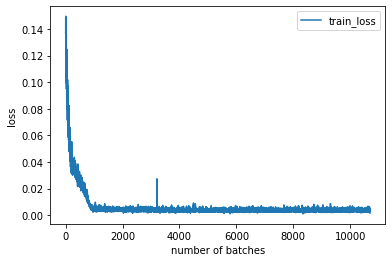

<Figure size 432x288 with 0 Axes>

In [15]:
#train_loss曲线
x = np.linspace(0,len(train_log),len(train_log))
plt.plot(x,train_log,label="train_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.5torchGRUtrainloss.jpg')
#plt.clf()

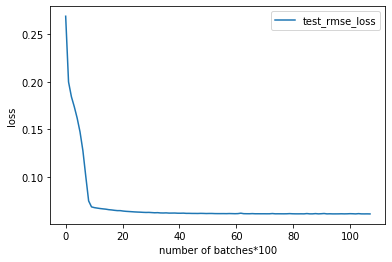

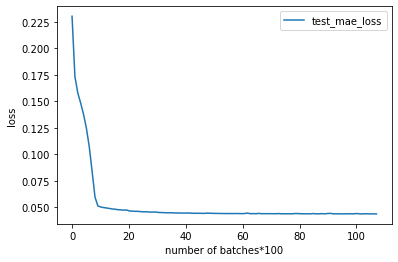

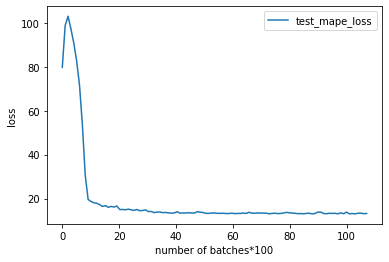

<Figure size 432x288 with 0 Axes>

In [16]:
#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.5torchGRUtestrmseloss.jpg')
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.5torchGRUtestrmaeloss.jpg')
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.5torchGRUtestrmapeloss.jpg')
#plt.clf()